# LOADING THE LIBRARIES

In [19]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.model_selection import train_test_split as splt
# for decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# for automated parameter tunning
from skopt import gp_minimize

## 1 IMPORTING THE DATASET

In [20]:
train = pd.read_csv('train.csv')
new_train = train.copy()
test = pd.read_csv('test.csv')
new_test = test.copy()

# FEATURE ENGINEERING

In [21]:
year = {1985:'aa',
        1987:'bb',
        1997:'cc',
        1998:'dd',
        1999:'ee',
        2002:'ff',
        2004:'gg',
        2007:'hh',
        2009:'ii'}
new_train['Outlet_Establishment_Year'] = new_train['Outlet_Establishment_Year'].map(year)
new_test['Outlet_Establishment_Year'] = new_test['Outlet_Establishment_Year'].map(year)

In [22]:
data = {'supermarket type1':'type1',
       'supermarket type2':'type2',
       'supermarket type3':'type3',
       'grocery store':'type4'}
new_train['Outlet_Type'] = new_train['Outlet_Type'].str.lower().map(data)
new_test['Outlet_Type'] = new_test['Outlet_Type'].str.lower().map(data)

In [23]:
data = {'low fat':'low_fat',
       'lf':'low_fat',
       'reg':'regular',
       'regular':'regular'}
new_train['Item_Fat_Content'] = new_train['Item_Fat_Content'].str.lower().map(data)
new_test['Item_Fat_Content'] = new_test['Item_Fat_Content'].str.lower().map(data)

In [24]:
data = {'tier 1':'tier_1',
       'tier 2':'tier_2',
       'tier 3':'tier_3'}
new_train['Outlet_Location_Type'] = new_train['Outlet_Location_Type'].str.lower().map(data)
new_test['Outlet_Location_Type'] = new_test['Outlet_Location_Type'].str.lower().map(data)

In [25]:
new_train['Item_Identifier'] = new_train.Item_Identifier.apply(lambda x: re.search(r'[A-Z]+',x).group())
new_test['Item_Identifier'] = new_test.Item_Identifier.apply(lambda x: re.search(r'[A-Z]+',x).group())

In [26]:
def convert(data):
    for i in list(data.columns):
        if np.issubdtype(data[i].dtype, np.object_) == True: 
            data[i] = data[i].str.upper()
    return data
new_train = convert(new_train)
new_test = convert(new_test)

In [27]:
def prepare(test,new_train,column):
    for i in list(np.arange(test[column].str.upper().nunique())):
        if sorted(new_train[column].str.upper().unique())[i] in sorted(test[column].str.upper().unique()):
            continue
        else:
            new_train = new_train.drop(new_train[new_train[column] == sorted(new_train[column].str.upper().unique())[i]].index)
    return new_train

In [28]:
new_train = prepare(new_test,new_train,'Item_Identifier')

In [29]:
# new_train['Item_Identifier'] = new_train.Item_Identifier.apply(lambda x: re.search(r'[A-Z]+',x).group())
# new_test['Item_Identifier'] = new_test.Item_Identifier.apply(lambda x: re.search(r'[A-Z]+',x).group())

In [30]:
print(new_train['Item_Identifier'].nunique())
print(new_test['Item_Identifier'].nunique())

71
71


In [31]:
def outlier(data):
    qmax = {}
    qmin = {}
    for i in list(data.columns):
        if(np.issubdtype(data[i].dtype, np.number) == True):
            iqr = data[i].quantile(0.75) - data[i].quantile(0.25)
            qmax[i] = data[i].quantile(0.75) + 1.5*iqr
            qmin[i] = data[i].quantile(0.25) - 1.5*iqr

    for i in list(data.columns):
        if(np.issubdtype(data[i].dtype, np.number) == True):
            data = data.drop(data[(data[i] > qmax[i]) | (data[i] < qmin[i])].index)
    return data

In [32]:
# new_train = outlier(new_train)

## FILLING THE NA VALES

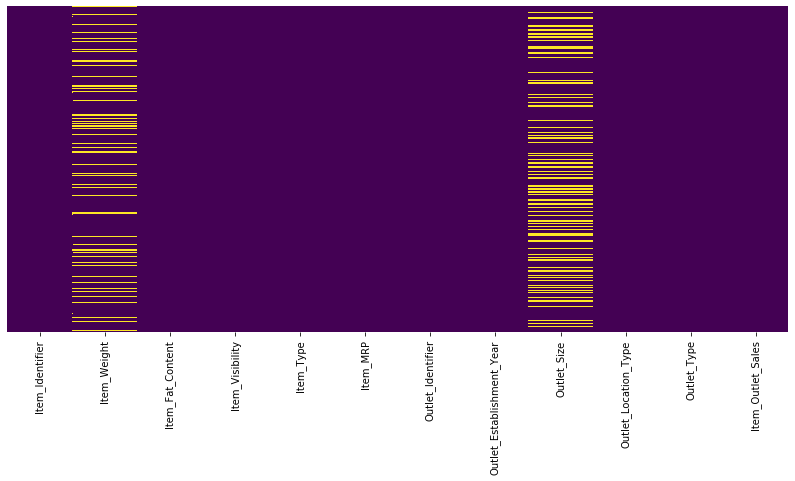

In [33]:
plt.figure(figsize=[14,6])
sns.heatmap(new_train.isna(),yticklabels=False,cbar=False,cmap='viridis')

In [34]:
new_train.fillna(method='bfill',inplace=True)
new_test.fillna(method='bfill',inplace=True)

In [35]:
X = new_train.drop('Item_Outlet_Sales',axis=1)
Y = new_train.Item_Outlet_Sales
print(X.shape)
print(Y.shape)

(8523, 11)
(8523,)


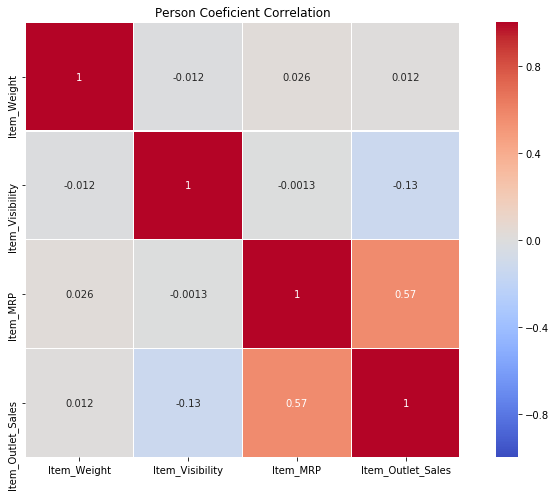

In [36]:
plt.figure(figsize=[13,8])
plt.title('Person Coeficient Correlation')
sns.heatmap(new_train.corr(),linewidths=0.1,vmax=1.0,vmin=-1.0,
            cmap='coolwarm',linecolor='white',annot=True,square=True)
plt.show()

## CREATING DUMMY VARIABLES

In [19]:
def dummyVariable(dataset):
    col = dataset
    for i in list(col.columns):
        if np.issubdtype(dataset[i].dtype, np.object_) == True:
            data = pd.get_dummies(dataset[i], drop_first= True)
            dataset = pd.concat([dataset,data], axis=1)
            dataset.drop(i,axis=1,inplace=True)
    return dataset

In [20]:
X = dummyVariable(X)
print(X.shape)
new_test = dummyVariable(new_test)
print(new_test.shape)

(8523, 113)
(5681, 113)


## SPLITTING THE DATA INTO TRAIN AND TEST FOR SAMPLE MODELS

In [21]:
X_train, X_test, Y_train, Y_test = splt(X, Y, test_size=0.2346, random_state=0)
print(X_test.shape)
print(X_train.shape)

(2000, 113)
(6523, 113)


## FEATURE SCALING

In [22]:
scale = StandardScaler()

In [23]:
def trainScale(train):
    data = train
    train = scale.fit_transform(train)
    train = pd.DataFrame(train, columns=data.columns)
    return train

def testScale(test):
    data = test
    test = scale.transform(test)
    test = pd.DataFrame(test, columns=data.columns)
    return test

In [24]:
X = trainScale(X)
new_test = testScale(new_test)

In [25]:
X_train = testScale(X_train)
X_test = testScale(X_test)

## SAMPLE MODELS

In [299]:
sModels, sPredictions, data = {}, {}, {}

In [300]:
data['regressor'] = 'decisionTree,extraTree,gbr,xgb'.split(',')
data['name'] = ['sampleModel/decisionTree.joblib',
                'sampleModel/extraTree.joblib',
                'sampleModel/gbr.joblib',
                'sampleModel/xgb.joblib']
data['models'] = [DecisionTreeRegressor(),
                 ExtraTreesRegressor(n_jobs=-1),
                 GradientBoostingRegressor(),
                 XGBRegressor(n_jobs=-1)]

In [301]:
# regressor[data['regressor'][3]] = data['models'][3]
# regressor[data['regressor'][3]] = regressor[data['regressor'][3]].fit(X_train,Y_train)
# dump(regressor[data['regressor'][3]],data['name'][3])
sModels[data['regressor'][3]] = load(data['name'][3])

[16:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [302]:
sPredictions['xgb'] = sModels[data['regressor'][3]].predict(X_test)

In [303]:
rmse = np.sqrt(np.mean(np.square(sPredictions['xgb'] - Y_test),axis=0))
rmse

1095.6908320685054

### 6.1 CROSS VALIDATION

In [304]:
regressor = XGBRegressor()

In [305]:
# scores = cross_val_score(regressor, X, Y, cv=10, n_jobs=-1)

In [306]:
scores.mean()

0.5944312823029622

### 6.2 HYPERPARAMETER TUNNING

In [307]:
regressor = XGBRegressor()

In [308]:
params = {'learning_rate':list(np.arange(0.01,1.01,0.01)),
         'n_estimators':list(np.arange(100,500,1)),
         'max_depth':list(np.arange(1,11,1)),
         'subsample':list(np.arange(0.1,1.1,0.1))}

In [314]:
randomSearch = RandomizedSearchCV(regressor, params, cv=10,n_jobs=-1)

In [315]:
randomSearch = randomSearch.fit(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [316]:
# dump(randomSearch,'originalModel/xgbtune.joblib')

['originalModel/xgbtune.joblib']

In [26]:
randomSearch = load('originalModel/xgbtune.joblib')

[07:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [318]:
print(randomSearch.best_params_)
print(randomSearch.best_score_)

{'subsample': 0.8, 'n_estimators': 257, 'max_depth': 6, 'learning_rate': 0.03}
0.5823434962249664


### 6.3 PREDICTIONS

In [29]:
regressor = XGBRegressor(subsample=0.8,n_estimators=257,
                        max_depth=6,learning_rate=0.03,n_jobs=-1)
regressor = regressor.fit(X,Y)
predictions = regressor.predict(new_test)
submission = pd.DataFrame({'Item_Identifier':list(test.Item_Identifier),
                          'Outlet_Identifier':list(test.Outlet_Identifier),
                          'Item_Outlet_Sales':list(predictions)})

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[07:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [31]:
submission.to_csv('submission/submission5.csv',index=False)

## ORIGINAL MODELS

In [175]:
oModels, oPredictions = {}, {}

In [176]:
data['regressor'] = 'decisionTree,extraTree,gbr,xgb'.split(',')
data['name'] = ['originalModel/decisionTree.joblib',
                'originalModel/extraTree.joblib',
                'originalModel/gbr.joblib',
                'originalModel/xgb.joblib']
data['models'] = [DecisionTreeRegressor(),
                 ExtraTreesRegressor(n_jobs=-1),
                 GradientBoostingRegressor(),
                 XGBRegressor(n_jobs=-1)]
for i in np.arange(0,4):
    regressor = data['models'][i]
    regressor = regressor.fit(X,Y)
    dump(regressor,data['name'][i])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
for i in np.arange(0,4):
    oModels[data['regressor'][i]] = load(data['name'][i])

In [177]:
# print('Decision Tree:',oModels['decisionTree'].best_score_)
# print('Xtreme Random Forest Tree:',oModels['extraTree'].best_score_)
# print('Gradient Boosting:',oModels['gbr'].best_score_)
# print('Xtreme Gradient Boosting',oModels['xgb'].best_score_)

In [178]:
data['submission'] = ['submission/submission1.csv',
                      'submission/submission2.csv',
                      'submission/submission3.csv',
                      'submission/submission4.csv']
for i in np.arange(0,4):
    oPredictions = oModels[data['regressor'][i]].predict(new_test)
    submission = pd.DataFrame({'Item_Identifier':list(test.Item_Identifier),
                              'Outlet_Identifier':list(test.Outlet_Identifier),
                              'Item_Outlet_Sales':list(oPredictions)})
    submission.to_csv(data['submission'][i],index=False)